In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio
import shapely
import random
import os

from shapely.geometry import shape
from shapely.geometry import Point

import pystac_client
import planetary_computer as pc

import random
random.seed(10)

In [2]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* CAMPUS POINT NAIP SCENE *********
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
# we only need the image at this point to access the datasets crs

In [3]:
fp = os.path.join(os.getcwd(),'aux_data','non_iceplant_vegetation/non_iceplant_vegetation.shp')
polys = gpd.read_file(fp)

polys.to_crs(ds.crs,inplace=True)

In [4]:
polys['area'] = polys.geometry.apply(lambda p : p.area)
polys.sort_values(by='area',ascending=False,inplace=True)
polys.reset_index(drop=True,inplace=True)
polys['iceplant']=0
polys.head()

,id,geometry,area,iceplant
0,39,"POLYGON ((236855.151 3814564.885, 237270.921 3...",51712.329780,0
1,33,"POLYGON ((240467.235 3812458.278, 240550.889 3...",18119.799182,0
2,36,"POLYGON ((240344.254 3813738.980, 240564.625 3...",16942.445742,0
3,40,"POLYGON ((236791.473 3814122.898, 237032.446 3...",15001.990968,0
4,34,"POLYGON ((240831.815 3812641.817, 241016.602 3...",11517.887411,0


<AxesSubplot:>

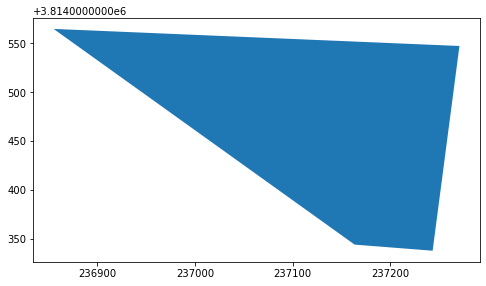

In [5]:
# pick biggest polygon
biggest = polys.filter(items=[0],axis=0).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)

In [7]:
def random_pts_poly(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  

In [8]:
proportion = 0.4
# calculating how many pixels are there in the polygon (approx), by dividing the area of poly by area of a single pixel
pixels_in_poly = int(biggest.area/(ds.res[0]*ds.res[1])) 
N= int(pixels_in_poly * proportion)
# BEFORE N=25
# DEFINE NUMBER OF RANDOM POINTS TO BE SELECTED ON BIGGEST POLYGON
# the rest of the polygons will have a number of polygons proportional to their area

points = random_pts_poly(N,biggest['geometry'][0])
# ********** SIMPLIFY THIS ***************
geo_points = gpd.GeoDataFrame()
geo_points['geometry']=points
geo_points.set_crs(polys.crs,inplace=True)
# *******************************************************************

# fig, ax = plt.subplots()
# fig.set_size_inches((8,8))
# biggest.plot(ax=ax)
# geo_points.plot(ax=ax,color='yellow')

,geometry
0,POINT (237092.723 3814435.108)
1,POINT (237193.306 3814524.798)
2,POINT (237126.845 3814374.060)
3,POINT (237071.630 3814412.131)
4,POINT (236959.092 3814554.163)
...,...
57453,POINT (237105.579 3814430.235)
57454,POINT (237176.943 3814549.217)
57455,POINT (237036.954 3814471.384)
57456,POINT (237096.960 3814552.673)


In [12]:
big_area = biggest['geometry'][0].area
polys['num_random_pts'] = polys.area.apply(lambda a : int(a/big_area*N))
polys.drop('area',axis=1,inplace=True)
#polys

In [14]:
samples = []
for i in range(0,polys.shape[0]):
    poly = polys['geometry'][i]
    N = polys['num_random_pts'][i]
    
    points = random_pts_poly(N,poly)
    sample = pd.DataFrame({
        'geometry': pd.Series(points), 
        'iceplant':pd.Series(np.full(N,polys['iceplant'][i]))
                 })
    sample['xy']=sample.geometry.apply(lambda p :(p.x, p.y))
    
    data_generator = ds.sample(sample.xy)
    data = []
    for i in data_generator:
        data.append(i)
    data = np.vstack(data)
    data = pd.DataFrame(data, columns=['r','g','b','nifr'])
    
    sample = pd.concat([sample,data],axis=1)
    samples.append(sample)



/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interfac

In [15]:
train_set = pd.concat(samples)
train_set['x']= train_set.geometry.apply(lambda p : p.x)
train_set['y']= train_set.geometry.apply(lambda p : p.y)
train_set.drop('xy',axis=1,inplace=True)
train_set.reset_index(drop=True,inplace=True)
train_set

,geometry,iceplant,r,g,b,nifr,x,y
0,POINT (237140.55244983404 3814526.1699873866),0,163,144,116,183,237140.552450,3.814526e+06
1,POINT (236884.12087633682 3814547.9049896635),0,114,103,95,140,236884.120876,3.814548e+06
2,POINT (237192.64798213766 3814447.7745699394),0,59,67,69,137,237192.647982,3.814448e+06
3,POINT (237097.1258511347 3814436.9883266105),0,132,117,107,138,237097.125851,3.814437e+06
4,POINT (237173.60862923032 3814382.449895106),0,146,126,107,165,237173.608629,3.814382e+06
...,...,...,...,...,...,...,...,...
193340,POINT (237992.3680607603 3811235.076533154),0,34,43,64,48,237992.368061,3.811235e+06
193341,POINT (237988.41370572444 3811232.482522697),0,84,95,105,89,237988.413706,3.811232e+06
193342,POINT (237990.76346040718 3811236.3752342667),0,82,86,87,113,237990.763460,3.811236e+06
193343,POINT (237981.55392414864 3811229.551649573),0,88,89,93,120,237981.553924,3.811230e+06


In [16]:
train_set = train_set[['geometry','x','y','r','g','b','nifr','iceplant']]
train_set

,geometry,x,y,r,g,b,nifr,iceplant
0,POINT (237140.55244983404 3814526.1699873866),237140.552450,3.814526e+06,163,144,116,183,0
1,POINT (236884.12087633682 3814547.9049896635),236884.120876,3.814548e+06,114,103,95,140,0
2,POINT (237192.64798213766 3814447.7745699394),237192.647982,3.814448e+06,59,67,69,137,0
3,POINT (237097.1258511347 3814436.9883266105),237097.125851,3.814437e+06,132,117,107,138,0
4,POINT (237173.60862923032 3814382.449895106),237173.608629,3.814382e+06,146,126,107,165,0
...,...,...,...,...,...,...,...,...
193340,POINT (237992.3680607603 3811235.076533154),237992.368061,3.811235e+06,34,43,64,48,0
193341,POINT (237988.41370572444 3811232.482522697),237988.413706,3.811232e+06,84,95,105,89,0
193342,POINT (237990.76346040718 3811236.3752342667),237990.763460,3.811236e+06,82,86,87,113,0
193343,POINT (237981.55392414864 3811229.551649573),237981.553924,3.811230e+06,88,89,93,120,0


In [17]:
train_fp = os.path.join(os.getcwd(),'aux_data','trainset_non_iceplant_vegetation.csv')
train_set.to_csv(train_fp)

In [20]:
#copy = train_set.drop(['geometry','x','y'],axis=1)
copy.drop_duplicates(subset = ['r','g','b','nifr'])

,r,g,b,nifr,iceplant
0,163,144,116,183,0
1,114,103,95,140,0
2,59,67,69,137,0
3,132,117,107,138,0
4,146,126,107,165,0
...,...,...,...,...,...
193340,34,43,64,48,0
193341,84,95,105,89,0
193342,82,86,87,113,0
193343,88,89,93,120,0


In [21]:
193345 - 145982

47363